# Arrival Rate vs Latency Analysis

This notebook analyzes the relationship between arrival rate and average latency in the MBPP testing results.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# CSV path
csv_path = "../logs/motivation_baseline_mbpp_arrival_rate_100.csv"

In [4]:
# Load the data
df = pd.read_csv(csv_path)

# Display basic information
print(f"Total rows: {len(df)}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Total rows: 7136

Columns: ['run_id', 'dataset', 'split', 'batch_id', 'item_id', 'record_type', 'task_name', 'reasoning_name', 'decision_method', 'graph_id', 'num_rounds', 'num_agents', 'agent_roles_json', 'agent_llms_json', 'role_llm_map_json', 'workflow_latency_seconds', 'llm_elapsed_seconds', 'node_id', 'node_name', 'role_name', 'llm_name', 'is_decision_node', 'round_idx', 'attempts', 'success', 'error', 'ts_start', 'ts_end', 'duration_sec', 'cost_delta', 'prompt_tokens', 'completion_tokens', 'total_tokens', 'output_text', 'router_log_prob', 'router_task_probs_json', 'router_agent_num_pred', 'utility', 'quality_is_correct', 'quality_pred', 'quality_gold', 'quality_feedback', 'quality_state_json', 'eval_duration_sec', 'arrival_rate', 'arrival_pattern']

First few rows:


,run_id,dataset,split,batch_id,item_id,record_type,task_name,reasoning_name,decision_method,graph_id,...,router_agent_num_pred,utility,quality_is_correct,quality_pred,quality_gold,quality_feedback,quality_state_json,eval_duration_sec,arrival_rate,arrival_pattern
0,2026-01-25-16-19-55,mbpp,test,0.0,82,workflow,Code,Chain,FinalRefer,TSdR,...,4.396265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2026-01-25-16-19-55,mbpp,test,0.0,82,node,Code,Chain,FinalRefer,TSdR,...,4.396265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2026-01-25-16-19-55,mbpp,test,0.0,82,node,Code,Chain,FinalRefer,TSdR,...,4.396265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2026-01-25-16-19-55,mbpp,test,0.0,82,node,Code,Chain,FinalRefer,TSdR,...,4.396265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2026-01-25-16-19-55,mbpp,test,0.0,82,node,Code,Chain,FinalRefer,TSdR,...,4.396265,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Filter for quality records only (these contain the arrival_rate and workflow metrics)
quality_df = df[df['record_type'] == 'quality'].copy()

print(f"Quality records: {len(quality_df)}")
print(f"\nArrival rates in data: {quality_df['arrival_rate'].unique()}")
print(f"\nArrival pattern: {quality_df['arrival_pattern'].unique()}")

Quality records: 900

Arrival rates in data: [100.  50.  10. 150.]

Arrival pattern: ['poisson']


In [6]:
# Calculate average latency per arrival rate for workflow_latency_seconds

# For workflow latency - from quality records
workflow_latency_by_rate = quality_df.groupby('arrival_rate')['workflow_latency_seconds'].agg(
    mean='mean',
    std='std',
    count='count'
).reset_index()

print("Workflow Latency by arrival rate:")
print(workflow_latency_by_rate)

Workflow Latency by arrival rate:
   arrival_rate       mean        std  count
0          10.0  15.762664  12.175786    200
1          50.0  19.533143  13.563350    300
2         100.0  27.000997  15.525706    200
3         150.0  37.145291  52.404547    200


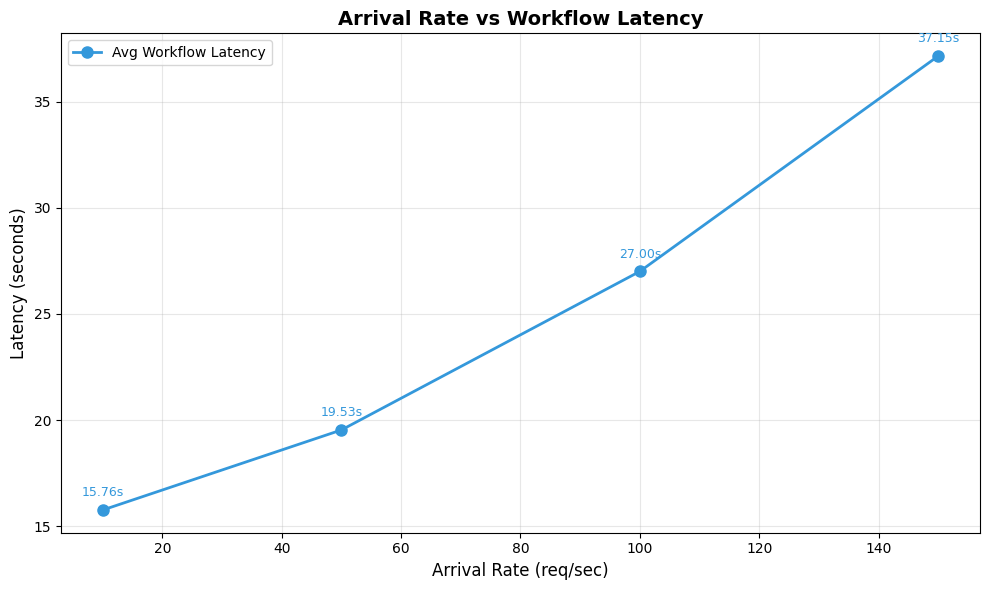

In [7]:
# Create the plot with average workflow latency
plt.figure(figsize=(10, 6))

# Plot average workflow latency
plt.plot(workflow_latency_by_rate['arrival_rate'], 
         workflow_latency_by_rate['mean'],
         marker='o', 
         markersize=8,
         linewidth=2,
         color='#3498db',
         label='Avg Workflow Latency')

plt.xlabel('Arrival Rate (req/sec)', fontsize=12)
plt.ylabel('Latency (seconds)', fontsize=12)
plt.title('Arrival Rate vs Workflow Latency', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

# Add value labels on the points
for idx, row in workflow_latency_by_rate.iterrows():
    plt.annotate(f"{row['mean']:.2f}s", 
                 (row['arrival_rate'], row['mean']),
                 textcoords="offset points",
                 xytext=(0, 10),
                 ha='center',
                 fontsize=9,
                 color='#3498db')

plt.tight_layout()
plt.show()

In [8]:
# Calculate throughput (requests per second) for each arrival rate
# Throughput = 1 / average_latency

throughput_workflow = workflow_latency_by_rate.copy()
throughput_workflow['throughput'] = 1 / throughput_workflow['mean']

print("Throughput by arrival rate (based on Workflow Latency):")
print(throughput_workflow[['arrival_rate', 'mean', 'throughput']])

Throughput by arrival rate (based on Workflow Latency):
   arrival_rate       mean  throughput
0          10.0  15.762664    0.063441
1          50.0  19.533143    0.051195
2         100.0  27.000997    0.037036
3         150.0  37.145291    0.026921


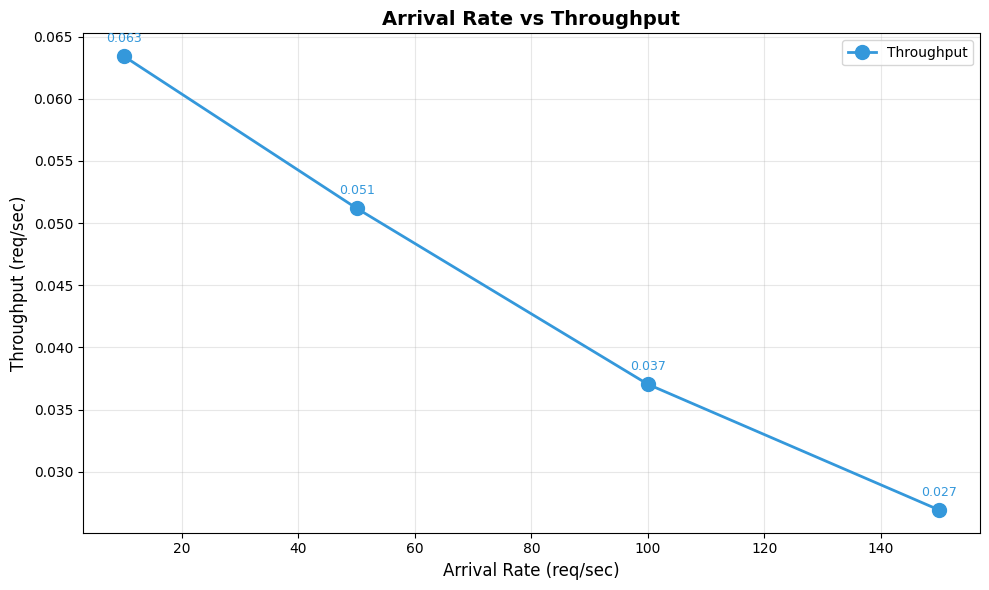

In [9]:
# Plot: Arrival Rate vs Throughput
plt.figure(figsize=(10, 6))

# Throughput based on average workflow latency
plt.plot(throughput_workflow['arrival_rate'], 
         throughput_workflow['throughput'],
         marker='o', 
         markersize=10,
         linewidth=2,
         color='#3498db',
         label='Throughput')

plt.xlabel('Arrival Rate (req/sec)', fontsize=12)
plt.ylabel('Throughput (req/sec)', fontsize=12)
plt.title('Arrival Rate vs Throughput', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

# Add value labels
for idx, row in throughput_workflow.iterrows():
    plt.annotate(f"{row['throughput']:.3f}", 
                 (row['arrival_rate'], row['throughput']),
                 textcoords="offset points",
                 xytext=(0, 10),
                 ha='center',
                 fontsize=9,
                 color='#3498db')

plt.tight_layout()
plt.show()

Request Distribution Among Models:
llm_name
deepseek-ai/DeepSeek-R1-Distill-Qwen-32B      434
meta-llama/Llama-3.1-8B-Instruct              523
mistralai/Mistral-Small-24B-Instruct-2501     532
meta-llama/Llama-3.2-3B-Instruct              535
Qwen/Qwen2.5-Coder-14B-Instruct              3312
Name: count, dtype: int64

Total LLM calls: 5336


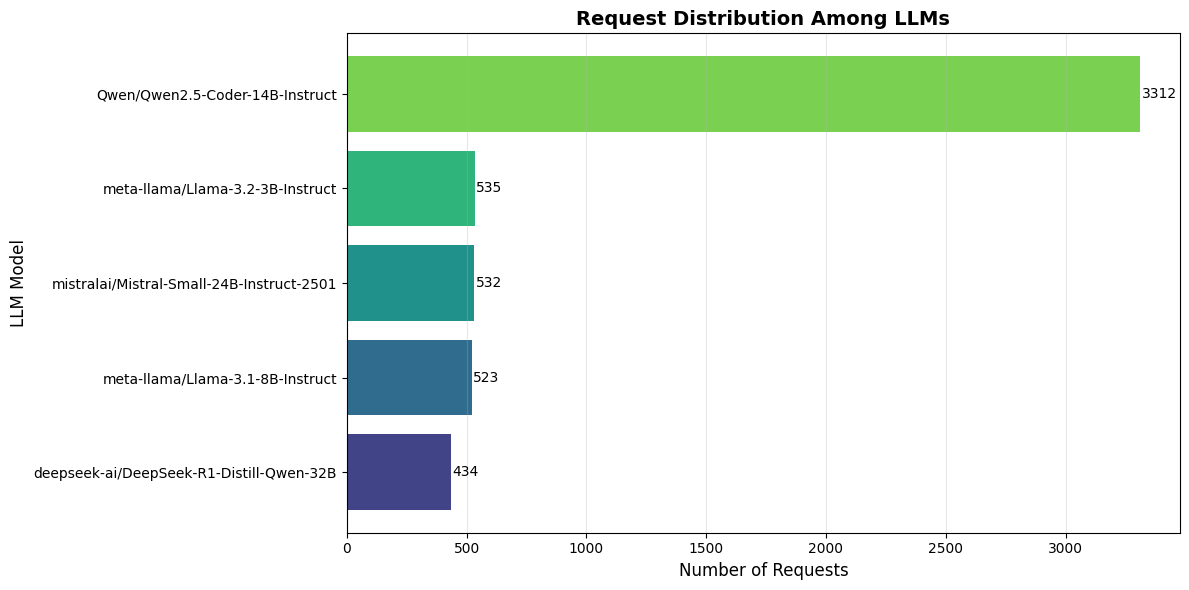

In [10]:
# Request Distribution Among Models
# Filter for node records (actual LLM calls)
node_df = df[df['record_type'] == 'node'].copy()

# Count requests per LLM
llm_counts = node_df['llm_name'].value_counts().sort_values(ascending=True)

print("Request Distribution Among Models:")
print(llm_counts)
print(f"\nTotal LLM calls: {llm_counts.sum()}")

# Create bar chart
plt.figure(figsize=(12, 6))

colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(llm_counts)))
bars = plt.barh(llm_counts.index, llm_counts.values, color=colors)

plt.xlabel('Number of Requests', fontsize=12)
plt.ylabel('LLM Model', fontsize=12)
plt.title('Request Distribution Among LLMs', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='x')

# Add value labels on bars
for bar, count in zip(bars, llm_counts.values):
    plt.text(bar.get_width() + 5, bar.get_y() + bar.get_height()/2, 
             f'{count}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

Request Distribution by Arrival Rate and LLM:
llm_name      Qwen/Qwen2.5-Coder-14B-Instruct  \
arrival_rate                                    
10.0                                     3312   
50.0                                     3312   
100.0                                    3312   
150.0                                    3312   

llm_name      deepseek-ai/DeepSeek-R1-Distill-Qwen-32B  \
arrival_rate                                             
10.0                                               434   
50.0                                               434   
100.0                                              434   
150.0                                              434   

llm_name      meta-llama/Llama-3.1-8B-Instruct  \
arrival_rate                                     
10.0                                       523   
50.0                                       523   
100.0                                      523   
150.0                                      523   

llm_name 

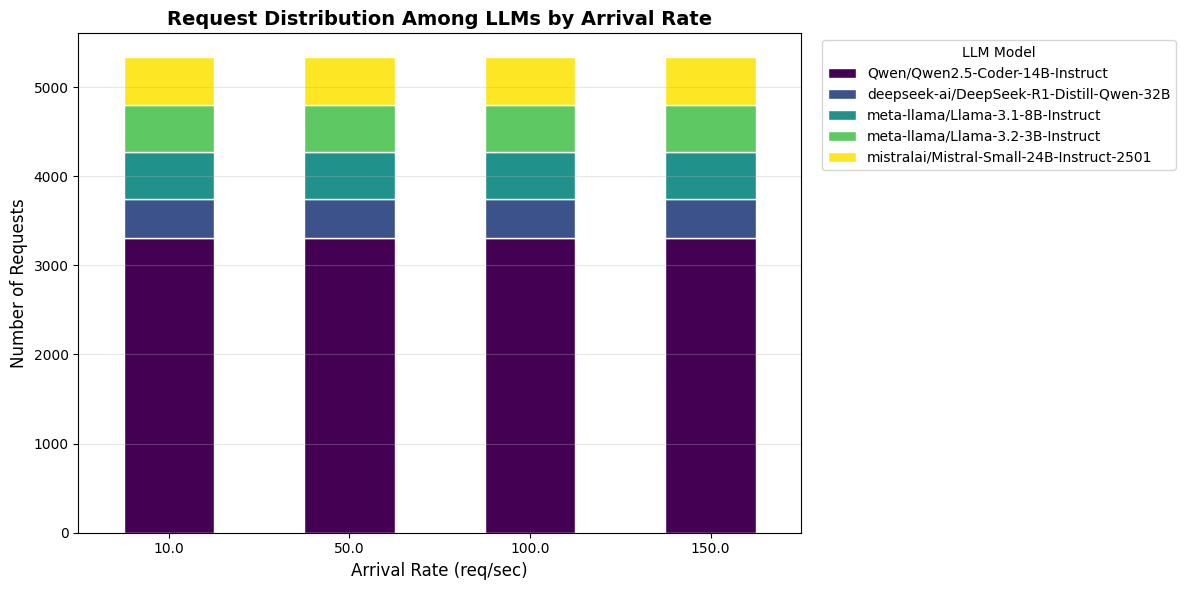

In [11]:
# Request Distribution by Arrival Rate
# Merge node records with arrival rate info from quality records
quality_arrival = quality_df[['item_id', 'arrival_rate']].drop_duplicates()
node_with_rate = node_df.merge(quality_arrival, on='item_id', how='left', suffixes=('', '_q'))

# Use the arrival_rate from quality records if node's is NaN
node_with_rate['arrival_rate'] = node_with_rate['arrival_rate_q'].fillna(node_with_rate['arrival_rate'])

# Group by arrival rate and LLM
llm_by_rate = node_with_rate.groupby(['arrival_rate', 'llm_name']).size().unstack(fill_value=0)

print("Request Distribution by Arrival Rate and LLM:")
print(llm_by_rate)

# Stacked bar chart
fig, ax = plt.subplots(figsize=(12, 6))

llm_by_rate.plot(kind='bar', stacked=True, ax=ax, colormap='viridis', edgecolor='white')

plt.xlabel('Arrival Rate (req/sec)', fontsize=12)
plt.ylabel('Number of Requests', fontsize=12)
plt.title('Request Distribution Among LLMs by Arrival Rate', fontsize=14, fontweight='bold')
plt.legend(title='LLM Model', bbox_to_anchor=(1.02, 1), loc='upper left')
plt.xticks(rotation=0)
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()